# **Measuring fairness in automatic skin disease diagnosis with a convolutional neural network**

The aim of this project is to measure fairness in automatic skin disease diagnosis using a
convolutional neural network. The dataset used for this work is a compilation of various images of skin diseases taken by the medical personnel from the pedriatic ward at Sant’Orsola hospital in Bologna. These images were collected using consumer-grade cameras, resulting in considerable variance in illumination, angle, and quality. The first part of this work involes processing the images to create a dataset with uniform image sizes. The second part focuses on determining the skin tone of each sample using the Individual Typology Angle. The third part involves training a simple convolutional neural network and evaluating its performance across different skin tones by computing traditional metrics for each skin tone and different fairness metrics.

# **First step: preprocessing the dataset with a cropping algorithm**

# 1. Initial setup: importing (and installing) the necessary libraries

In [ ]:
!pip install scikit-image

In [25]:
from pathlib import Path
from typing import List
import shutil
import numpy as np
import re
from PIL import Image
import os
from skimage import exposure, measure
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from generate_images import generate_croppings, generate_path_pairs # algorithm to obtain the crops

# 2. Generating crops with the cropping algorithm

The dataset is composed of about 8000 images taken with different consumer cameras. For this reason, the images are affected by high variability in illumination, angle, quality, size, blurriness, etc. Furthermore, the regions which contain the skin disease are not isolated.

**The algorithm used to process such images is adapted by  from the one developed by Alessandro D’Amico, Riccardo
Murgia and Mazeyar Moeini Feizabadi** [https://github.com/eskinderit/experiments-synthetic-generation-clinical-skin-images/blob/main/generate_images.ipynb . The functions used in the next cells are imported from the 'generate_images.py' file.

The idea is to detect the regions of the image in which the skin disease is present
by considering the binary mask of the image and employing a sliding-window
approach. In particular:

1. The algorithm starts from the top-left corner of the image and takes a
fixed-size patch (in our case the size is 256x256).

2. The algorithm extracts the binary mask relative to that patch and computes the disease coverage in that patch, i.e. the ratio of the positive
label (1) in the mask over the negative label (0). This is done to assess the
presence of contrast, which could indicate that the skin disease is present.
If the disease coverage is higher than a threshold (high contrast), the patch
is taken. If it is lower, the patch is discarded.

3. Repeat the process by sliding the patch extractor by a certain amount.
This process results in a lot of patches, the majority of which overlap and,
thus, are redundant. To overcome this issue, a non-maxima suppression procedure is run over the obtained patches: if two patches overlap over a certain limit,
the patch with lower disease coverage is discarded.
The last step involves discarding those crops which exhibit low contrast, in hope
of cleaning the dataset from poorly illuminated or blurry patches.

In [26]:
diseases = ['esantema-iatrogeno-farmaco-indotta', 'esantema-maculo-papuloso', 'esantema-morbilliforme', 'esantema-polimorfo-like',
            'esantema-virale', 'orticaria', 'pediculosi', 'scabbia', 'varicella']

In [3]:
##########
## Settings

# Image path settings
main_path = Path("C:\\Users\\maild\\Desktop\\Thesis")

# Cropping settings
crop_size = 256
crop_shift = 32
nms_th = 0.4
min_mask_ratio = 0.1

Important: the folder indicated by the 'main\_path' variable should contain the nine disease folders of the dataset for this code to work.

In [ ]:
for disease_folder in tqdm(diseases):
    img_mask_pairs = generate_path_pairs(main_path / disease_folder)
    generate_croppings(disease_folder, img_mask_pairs, (crop_size,crop_size), crop_shift=crop_shift, nms_threshold=nms_th, min_mask_ratio=min_mask_ratio)

## 2.1 Examples of generated crops

Important: after the previous steps, a 'colab/' folder with the nine diseases subfolders was created manually. Each disease subfolder contains **just the cropped images** (no masks). From now on, the code will only work if the 'colab/' folder is present. Alternatively, the following code will create the aforementioned folder with the subfolders (it will take some time).

In [ ]:
pattern = re.compile(r'^\d{1,6}\.png$')

# Create the colab folder if it doesn't exist
os.makedirs('colab', exist_ok=True)

for disease in diseases:
    crops_folder = os.path.join(disease, 'crops')

    # Define the destination folder in 'colab'
    dest_folder = os.path.join('colab', disease)

    # Create the destination disease folder in 'colab'
    os.makedirs(dest_folder, exist_ok=True)

    # Check if the crops folder exists
    if os.path.exists(crops_folder):
        for file_name in tqdm(os.listdir(crops_folder)):
            if pattern.match(file_name):
                # Define the full path for the source and destination files
                src_file = os.path.join(crops_folder, file_name)
                dest_file = os.path.join(dest_folder, file_name)

                # Copy the file to the destination folder
                shutil.copy2(src_file, dest_file)

    print(f"{disease} crops copied successfully.")

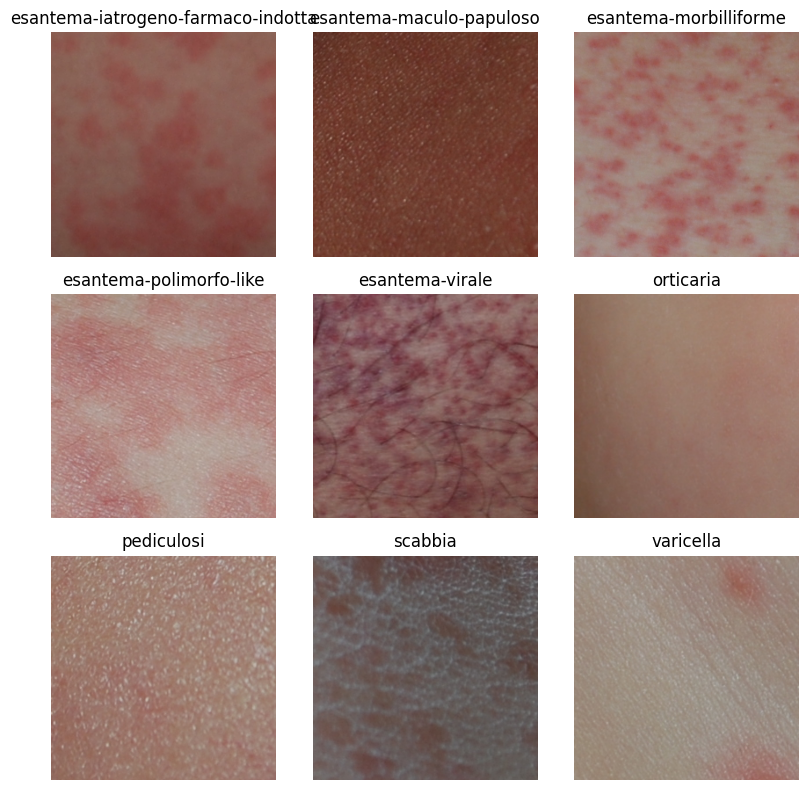

In [76]:
base_dir = 'colab/'

# Create a plot to display the 3x3 grid of images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, disease in enumerate(diseases):

    # randomly choose an image
    disease_folder = os.path.join(base_dir, disease)
    image_files = [f for f in os.listdir(disease_folder) if f.endswith('.png')]
    img_file = random.choice(image_files)

    # Open the image
    img_path = os.path.join(disease_folder, img_file)
    img = Image.open(img_path)

    # Plot the image on the 3x3 grid
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{disease}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

We can clearly see that, despite our efforts, not all crops are of good quality: the generated crops contain several artifacts, such as blurrying, poor illumination, regions in which the disease is not present, unnecessary body parts and edges.

# **Second step: computation of the skin color using the Individual Typology Angle**

## 1. Initial setup: importing (and installing) the necessary libraries

In [ ]:
!pip install derm-ita

In [76]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from datasets import Dataset
from pathlib import Path
import re
from create_masks import create_masks
import shutil
import pandas as pd
from derm_ita import get_ita
from sklearn.mixture import GaussianMixture
import math

# 2. Creating new masks

The following code will:
- create new binary masks and store them in the folder named 'crops_masks' in the directory relative to each disease; this is necessary to perform the 'bitwise and' operation between the original image and the binary mask, to assure that the ITA computation involves only the regions of skin in which the disease is **not** present.
- copy the cropped images from the 'crops' directory to the 'crops_masks' directory.

In [77]:
diseases = ['esantema-iatrogeno-farmaco-indotta', 'esantema-maculo-papuloso', 'esantema-morbilliforme', 'esantema-polimorfo-like',
            'esantema-virale', 'orticaria', 'pediculosi', 'scabbia', 'varicella']

In [ ]:
# create masks and copy the original images to the crops_masks folder
for disease in tqdm(diseases):
    create_masks(disease)
    base_folder=Path(os.path.join(os.getcwd(), disease, 'crops'))

    for file in [file for file in base_folder.glob("*.png") if re.match(r'\d+\.png', os.path.basename(file))]:
        shutil.copy(file, Path(os.path.join(os.getcwd(), disease, 'crops_masks')))

# 3. Plotting RGB distributions

In [20]:
# Initialize lists to store color intensities
skin_colors = {'reds': [], 'greens': [], 'blues': []}

for disease in diseases:

    disease_folder = Path(f'{disease}/crops')
    length = len([file for file in disease_folder.glob("*.png") if re.match(r'\d+\.png', os.path.basename(file))])

    # Process images and masks
    for i in tqdm(range(1, length+1)):
        # Format image number
        image_number = str(i).zfill(4)

        # Read image and mask
        image = cv2.imread(f'{disease}/crops_masks/{image_number}.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(f'{disease}/crops_masks/{image_number}_mask.png')
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)

        # Apply the mask to the image
        masked_channels = np.stack([cv2.bitwise_and(image[..., i], image[..., i], mask=image_mask[..., 0]) for i in range(3)])

        # Calculate the mean of non-black pixels in the masked image
        if np.any(masked_channels):
            r, g, b = [int(np.mean(masked_channels[i, ...][masked_channels[i]!=0])) for i in range(3)]
        else:
            r, g, b = [int(np.mean(image[i, ...][image[i]!=0])) for i in range(3)]

        # Append color intensities to lists
        skin_colors['reds'].append(r)
        skin_colors['greens'].append(g)
        skin_colors['blues'].append(b)

  0%|          | 0/27683 [00:00<?, ?it/s]

  0%|          | 0/11994 [00:00<?, ?it/s]

  0%|          | 0/5919 [00:00<?, ?it/s]

  0%|          | 0/12398 [00:00<?, ?it/s]

  0%|          | 0/85080 [00:00<?, ?it/s]

  0%|          | 0/134422 [00:00<?, ?it/s]

  0%|          | 0/10369 [00:00<?, ?it/s]

  0%|          | 0/32390 [00:00<?, ?it/s]

  0%|          | 0/9405 [00:00<?, ?it/s]

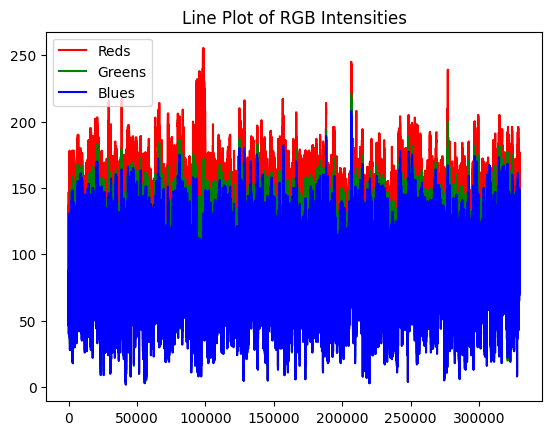

In [21]:
plt.plot(skin_colors['reds'], color='red', label='Reds')
plt.plot(skin_colors['greens'], color='green', label='Greens')
plt.plot(skin_colors['blues'], color='blue', label='Blues')
plt.title('Line Plot of RGB Intensities')
plt.legend()

# 4. Extracting skin tones with Individual Typology Angle

The Individual Typology Angle (ITA) is used to determine the skin tone of an image. Its formula is defined as:
$$ITA = arctan(\frac{L^{*}-50}{b^{*}}) \cdot \frac{180^{\circ}}{\pi}$$
in the CIELAB color space, where $L^{*}$ represents the perceptual lightness and $b^{*}$ represents the blue-yellow opponents.
To compute the ITA value, the *get_ita* function from the derm-ita library was used.

In [79]:
def compute_ita(image_path):
    
    image_rgb = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)
    # Convert RGB image to Lab color space
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    # Split into L, a, b channels
    L, a, b = cv2.split(image_lab)
    L = np.where(L != 0, L, np.nan)
    b = np.where(b != 0, b, np.nan)
    #print(b)
    L, a, b = np.nanmean(L), np.nanmean(a), np.nanmean(b)
    
    # Calculate ITA for each pixel: ITA = arctan((L - 50) / b) * (180 / pi)
    ita = math.atan2(L - 50, b) * (180 / np.pi)
    
    return ita

In [78]:
def extract_skin_tone_ITA(img, mask):
    """
    Calculate Skin Color Approximation

    This function utilizes a provided mask to disregard imperfections in the image.
    It first performs a bitwise AND operation between the original image and the binary mask, removing the resulting black pixels
    and then flattening the image.
    After, it calls the 'get_ita' function from the derm-ita library to retrieve the ITA value of that image.

    Returns:
        The ITA value of the image.
    """

    # Apply the mask to the image with the bitwise AND
    masked_channels = np.stack([cv2.bitwise_and(img[..., i], img[..., i], mask=mask) for i in range(3)])
    #print(masked_channels.shape)

    masked_channels = np.transpose(masked_channels, (1,2,0))

    mask = np.any(masked_channels != [0, 0, 0], axis=-1) # remove black pixels
    masked_channels = masked_channels[mask] # remove black pixels (now it will be a flattened array)
    masked_channels = masked_channels[np.newaxis, ...] # augment the array of 1 dimension in order to preserve the three dimensions of rgb images

    # Calculate the ITA of non-black pixels in the masked image
    if np.any(masked_channels):
        #whole_image_ita = get_ita(image=masked_channels, remove_boarder=False)
        whole_image_ita = compute_ita(masked_channels)

    else: # default ITA value in case the pixels are all black
        whole_image_ita = -300

    return whole_image_ita

In [80]:
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
from torchvision.datasets.utils import list_files

diseases_ITA_value = {"img_path": [], "ita_value": []}

for disease in diseases:

    image_paths = [f"leonardo/colab/{disease}/{i}" for i in list_files(f"leonardo/colab/{disease}", IMG_EXTENSIONS)]
    diseases_ITA_value["img_path"] += image_paths

    disease_folder = Path(f'{disease}/crops')
    length = len([file for file in disease_folder.glob("*.png") if re.match(r'\d+\.png', os.path.basename(file))])

    # Process images and masks
    for i in tqdm(range(0, length)):
        image_path = image_paths[i]

        # Read image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(f"{disease}/crops_masks/" + image_path.split("/")[-1].replace(".png", "_mask.png"))
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)

        # Extract skin tone from the image
        ita_value = extract_skin_tone_ITA(image, image_mask[..., 0])

        diseases_ITA_value["ita_value"].append(ita_value)
    print(f'{disease} processed!')

  0%|          | 0/27683 [00:00<?, ?it/s]

esantema-iatrogeno-farmaco-indotta processed!


  0%|          | 0/11994 [00:00<?, ?it/s]

esantema-maculo-papuloso processed!


  0%|          | 0/5919 [00:00<?, ?it/s]

esantema-morbilliforme processed!


  0%|          | 0/12398 [00:00<?, ?it/s]

esantema-polimorfo-like processed!


  0%|          | 0/85080 [00:00<?, ?it/s]

esantema-virale processed!


  0%|          | 0/134422 [00:00<?, ?it/s]

orticaria processed!


  0%|          | 0/10369 [00:00<?, ?it/s]

pediculosi processed!


  0%|          | 0/32390 [00:00<?, ?it/s]

scabbia processed!


  0%|          | 0/9405 [00:00<?, ?it/s]

varicella processed!


## 4.1 Checking the distribution of the ITA values and finding the optimal ranges with Gaussian Mixture

We start by plotting the distribution of the ITA values across the dataset. We can see that the distribution resembles a Gaussian.

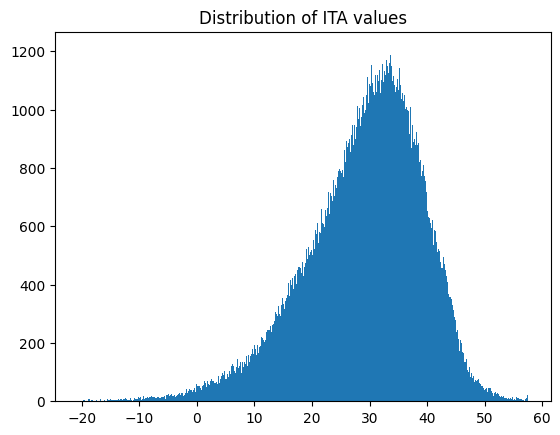

In [81]:
array_list = diseases_ITA_value["ita_value"]

array = np.array(array_list)
min_value = np.min(array[array != -300])

array = array[array != -300] 

values, bins, patches = plt.hist(array, bins=1000)
plt.title("Distribution of ITA values")

order = np.argsort(values)[::-1]

plt.show()

We know retrieve the decision boundaries to associate each ITA value to its corresponding skin tone:
- we fit the ITA values distribution with a Gaussian Mixture with six components
- we retrieve the decision boundaries (thresholds) relative to each Gaussian analytically

[25.02878746]
GMM-based cluster centers (means): [-3.31561216 11.09737726 21.29170701 29.45874663 35.60450325 41.72048681]
Calculated thresholds for skin tones: [3.8908825485804783, 16.194542136009495, 25.375226818525324, 32.53162493682256, 38.66249502605597]


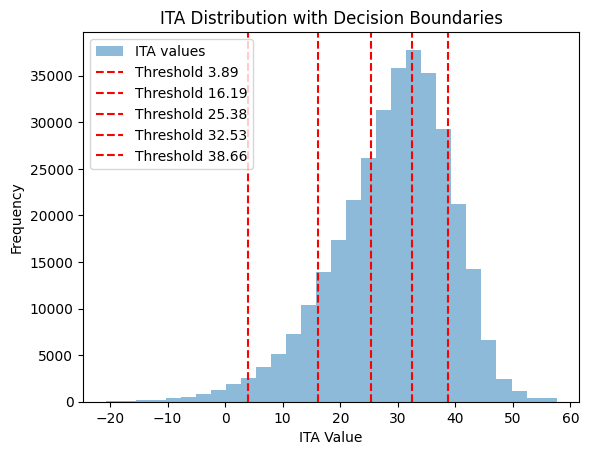

In [83]:
from scipy.stats import norm
from sklearn.mixture import BayesianGaussianMixture

# Fit GMM with 6 components
gmm = GaussianMixture(n_components=6, random_state=0, covariance_type='tied', tol=1e-4) #means_init=np.expand_dims(np.array([2, 5.72024944, 22.47880922, 29.17136651, 35.33638533, 41.43397786]), axis=1))
gmm.fit(array.reshape(-1, 1))

# Get the means and covariances of the Gaussian components
means = np.sort(gmm.means_.flatten())
covariances = gmm.covariances_.flatten()

# Calculate the decision boundaries (thresholds)
thresholds = []
print(covariances)
for i in range(len(means) - 1):
    mean1, mean2 = means[i], means[i + 1]
    var1, var2 = covariances[0], covariances[0]

    # Calculate the decision boundary analytically for two Gaussians
    a = 1 / var1 - 1 / var2
    b = -2 * (mean1 / var1 - mean2 / var2)
    c = mean1**2 / var1 - mean2**2 / var2 - np.log(var2 / var1)

    # Solve the quadratic equation to find the threshold
    threshold = np.roots([a, b, c])

    # Choose the threshold that lies between the two means
    threshold = threshold[(threshold > mean1) & (threshold < mean2)][0]
    thresholds.append(threshold)

# Print the means (cluster centers) and the calculated thresholds
print("GMM-based cluster centers (means):", means)
print("Calculated thresholds for skin tones:", thresholds)

# Plot the results
plt.hist(array, bins=30, alpha=0.5, label='ITA values')

for t in thresholds:
    plt.axvline(t, color='red', linestyle='--', label=f'Threshold {t:.2f}')
plt.xlabel('ITA Value')
plt.ylabel('Frequency')
plt.title('ITA Distribution with Decision Boundaries')
plt.legend()
plt.show()

We apply the found thresholds to our ITA values to label each image with its corresponding skin tone. In particular, the six possible values for the skin tone are:
1. **very light** (type 1 on the Fitzpatrick scale)
2. **light** (type 2)
3. **intermediate** (type 3)
4. **tan** (type 4)
5. **brown** (type 5)
6. **dark** (type 6)

Finally, we visualize the distribution of the six different skin tones across the dataset.

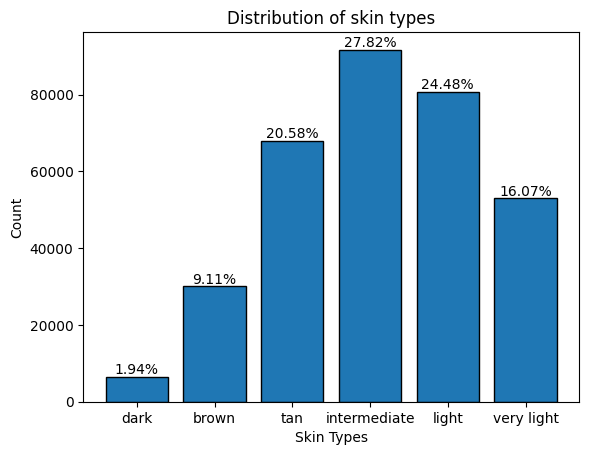

In [84]:
def get_type(ita_value): # function to apply the thresholds and retrieve the skin type
    if ita_value < thresholds[0]:
        ita_type = 'dark'
    elif ita_value >= thresholds[0] and ita_value < thresholds[1]:
        ita_type = 'brown'
    elif ita_value >= thresholds[1] and ita_value < thresholds[2]:
        ita_type = 'tan'
    elif ita_value >= thresholds[2] and ita_value < thresholds[3]:
        ita_type = 'intermediate'
    elif ita_value >= thresholds[3] and ita_value < thresholds[4]:
        ita_type = 'light'
    elif ita_value >= thresholds[4]:
        ita_type = 'very light'

    return ita_type

func = np.vectorize(get_type)

type_array = func(array)

# Define the correct order of the skin types
skin_types_order = ['dark', 'brown', 'tan', 'intermediate', 'light', 'very light']

# Get the counts for each skin type in the correct order
counts = [np.sum(type_array == skin_type) for skin_type in skin_types_order]

# Plot the histogram
plt.bar(skin_types_order, counts, edgecolor='black')

# Calculate percentages and annotate
total_count = len(type_array)
for i, count in enumerate(counts):
    percentage = f'{(count / total_count) * 100:.2f}%'
    plt.text(i, count, percentage, ha='center', va='bottom')

# Set labels and title
plt.title("Distribution of skin types")
plt.ylabel("Count")
plt.xlabel("Skin Types")
plt.xticks(skin_types_order)  # Ensure labels are in the correct order

# Display the plot
plt.show()

We find the classification results into csv files to retrieve the labels later during step 3.

In [83]:
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import IMG_EXTENSIONS

diseases_skin_tones = {disease: [] for disease in diseases}

# making a new directory to save the csv files
os.makedirs('leonardo/colab/skin_color_datasets', exist_ok=True)

for disease in diseases:
    ita_values_list = [diseases_ITA_value["ita_value"][i] for i in range(len(diseases_ITA_value["ita_value"])) if disease in diseases_ITA_value["img_path"][i]]
    skin_labels_list = func(ita_values_list)

    img_path_list = [path for path in diseases_ITA_value["img_path"] if disease in path]

    disease_df = pd.DataFrame({'img_path': img_path_list, 'skin_label': skin_labels_list})

    disease_df.to_csv(f'leonardo/colab/skin_color_datasets/{disease}_ITA.csv', index=False)

# 5. Show some results of the classification

In [153]:
def plot_images(disease):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(f'leonardo/colab/skin_color_datasets/{disease}_ITA.csv')

    n = 6  # Number of samples to display
    sampled_df = df.sample(n=n)

    # Set up the plotting grid
    fig, axes = plt.subplots(1, n, figsize=(15, 5))

    # Iterate over each row in the sampled DataFrame
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['img_path']
        skin_tone = row['skin_label']

        # Open the image
        image = Image.open(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(f'Skin Tone: {skin_tone}')

    # Show the plot
    plt.tight_layout()
    plt.show()

As an example, we visualize the results of the skin tone classification for the **esantema morbilliforme**. We can clearly observe that the skin tone is misclassified when the image is subject to poor illumination, i.e. less illuminated images are wrongly classified as darker skin tones: the ITA computation is not so robust when it comes to poor illumination.

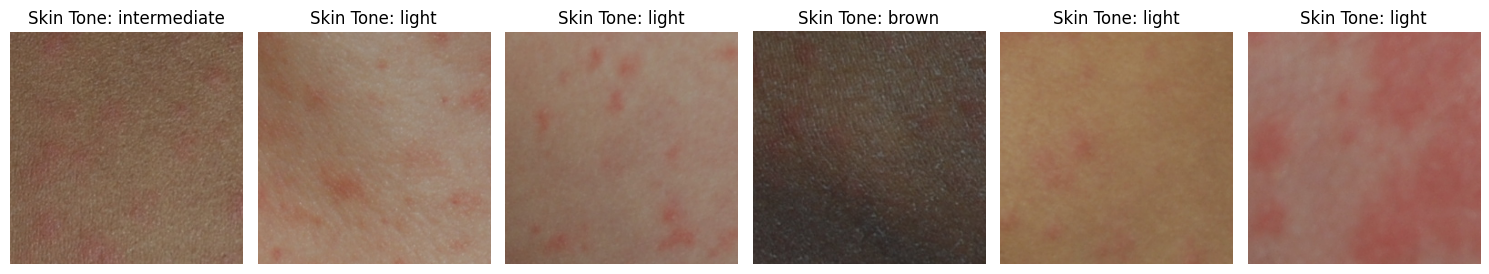

In [198]:
plot_images(diseases[1])

# **Third step: training a CNN and assessing its performance across the different skin tone groups**

# 1. Initial setup: importing (and installing) the necessary libraries

In [ ]:
!pip install fairlearn

In [ ]:
!pip install holisticai

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import f1_score
import os
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
from torchvision.datasets.utils import list_files
import re
from collections import Counter
import torch.optim.lr_scheduler as lr_scheduler
import random
from holisticai.bias.metrics import disparate_impact, precision_matrix
from fairlearn.metrics import equalized_odds_ratio

In [2]:
# settings: defining the folder path, the usual skin diseases list and the device (hopefully a GPU)
folder_path = 'colab'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

diseases = ['esantema-iatrogeno-farmaco-indotta', 'esantema-maculo-papuloso', 'esantema-morbilliforme', 'esantema-polimorfo-like',
                    'esantema-virale', 'orticaria', 'pediculosi', 'scabbia', 'varicella']

cpu


# 2. Building the dataset class

In [199]:
class CustomImageFolderColor(VisionDataset):
    def __init__(self, root, transform=transforms.ToTensor(), target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(diseases)}
        self.imgs = self._load_imgs()

    def _load_imgs(self):
        # here, I first create a dictionary which associates each image path to its skin label. After that, I incorporate this label in my data.

        imgs = []
        for disease in diseases:
          df = pd.read_csv(f"{self.root}/skin_color_datasets/{disease}_ITA.csv")
          skin_labels = df["skin_label"]
          img_paths = df["img_path"]

          imgs.extend([(img.replace("leonardo/", ""), skin_label, self.class_to_idx[disease]) for img, skin_label in zip(img_paths, skin_labels)])
        
        return imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, skin_label, target = self.imgs[idx]
        print(img_path)
        img = default_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, skin_label, target

In [201]:
###################### SET THE SEED FOR REPRODUCIBILITY ########################
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

############################### INSTANTIATING THE DATASET AND SPLITTING ###########################################
dataset = CustomImageFolderColor(folder_path)
print(len(dataset))

# Split the dataset into train and test sets
train_size = int(0.6 * len(dataset))  # 60% train, 20% validation, 20% test
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

329660


# 3. Building the network

The chosen model is a Convolutional Neural Network (CNN) with **five convolutional layers**, where each layer is followed by a MaxPooling layer. Each convolutional block doubles the channels and decreases the spatial dimension to capture high level features.

In [204]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(512 * 8 * 8, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, 512 * 8 * 8)
        x = self.fc(x)
        return x

# 4. Training the network

## 4.1 Training function

The training function uses an early stopper to prevent the waste of computational resources. At each epoch, the model is saved only if the mean F1 score of that epoch is higher than the previous one.

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
def train(net, EPOCHS, LEARNING_RATE, BATCH_SIZE, optimizer, criterion, scheduler, early_stopper, train_loader, validation_loader):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        train_loss = 0.0
        val_loss = 0.0
        running_loss = 0.0

        all_train_preds = []
        all_train_labels = []

        net.train()

        for i, data in tqdm(enumerate(train_loader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, _, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # store loss for plotting later
            train_loss += loss.item()
            running_loss += loss.item()

            # collect predictions and true labels for F1 score calculation
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu().numpy())

            # print statistics
            if i % 1000 == 0:    # print every 1000 mini-batches
                if i == 0:
                  print(f'[Epoch {epoch + 1}, Batch {i + 1:5d} / {len(train_loader)}] Training Loss: {running_loss}')
                else:
                  print(f'[Epoch {epoch + 1}, Batch {i + 1:5d} / {len(train_loader)}] Training Loss: {running_loss / 1000:.3f}')
                  running_loss = 0.0

        # Calculate training F1 score for the epoch
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_f1_scores.append(train_f1)

        train_losses.append(train_loss / len(train_loader))

        net.eval()  # Set the network to evaluation mode

        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():  # Disable gradient calculation for validation
            for i, data in tqdm(enumerate(validation_loader, 0)):
                inputs, _, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # collect predictions and true labels for F1 score calculation
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_val_preds.extend(preds)
                all_val_labels.extend(labels.cpu().numpy())

        # Calculate validation F1 score for the epoch
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        val_f1_scores.append(val_f1)
        val_losses.append(val_loss / len(validation_loader))

        print(f'[Epoch {epoch + 1}, Validation Loss: {val_loss / len(validation_loader):.3f}]')

        # save the model if validation loss is lower than previous epoch
        if val_f1_scores[epoch] > val_f1_scores[epoch-1]:
            torch.save(net.state_dict(), f'drive/MyDrive/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}.pth')

        # early stopping
        if early_stopper is not None:
          if early_stopper.early_stop(val_losses[epoch]):
            torch.save(net.state_dict(), f'drive/MyDrive/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_LASTEPOCH.pth')
            break

        # cosine annealing step
        if scheduler is not None:
          scheduler.step()
          current_lr = scheduler.get_last_lr()[0]
          print('UPDATING LEARNING RATE TO: ', current_lr)

    print('train_losses:', train_losses)
    print('validation_losses:', val_losses)
    print('train f1 scores: ', train_f1_scores)
    print('validation f1 scores: ', val_f1_scores)

    # save loss and F1 score plots to file
    # Plotting the training and validation loss
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'drive/MyDrive/plots/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}.png')

    print('Finished Training')

    torch.save(net.state_dict(), f'drive/MyDrive/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_LASTEPOCH.pth')

## 4.2 Hyperparameter tuning

The chosen optimizer and loss are SGD with momentum ($\mu$ = 0.9) and Binary Cross Entropy. The two hyperparameters which need to be optimized are the **learning rate** and the **batch size**. We try the following combinations of both:

1. learning rate = 0.01, batch size = 32
2. learning rate = 0.01, batch size = 64
3. learning rate = 0.01, batch size = 128
4. learning rate = 0.001, batch size = 64
5. learning rate = 0.001, batch size = 256
6. learning rate = 0.05, batch size = 128

We train the model for **five** epochs for each of these combinations, and choose the most promising combination to train the final model.

In [202]:
# Define the combinations of hyperparameters to try
combinations = [(32, 0.01), (64, 0.01), (128, 0.01), (64, 0.001), (256, 0.001), (128, 0.005)]

In [206]:
for num, combination in enumerate(combinations):

    ################################ DEFINING HYPERPARAMETER VALUES #########################################
    BATCH_SIZE, LEARNING_RATE = combination
    EPOCHS = 5

    print(f'**********************************TRAINING THE MODEL FOR {EPOCHS} EPOCHS, BATCH SIZE = {BATCH_SIZE} AND LEARNING RATE = {LEARNING_RATE}**********************************')

    # Create data loaders for train, validation and test sets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    ############################### INSTANTIATING THE MODEL #################################################
    net = Net(9).to(device)

    ############################### DEFINING THE LOSS AND THE OPTIMIZER #####################################
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

    ############################### TRAINING THE MODEL ######################################################
    train(net, EPOCHS, LEARNING_RATE, BATCH_SIZE, optimizer, criterion, None, None, train_loader, validation_loader)

print(net)

**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 32 AND LEARNING RATE = 0.01**********************************
**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 64 AND LEARNING RATE = 0.01**********************************
**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 128 AND LEARNING RATE = 0.01**********************************
**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 64 AND LEARNING RATE = 0.001**********************************
**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 256 AND LEARNING RATE = 0.001**********************************
**********************************TRAINING THE MODEL FOR 5 EPOCHS, BATCH SIZE = 128 AND LEARNING RATE = 0.005**********************************
Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

### 4.2.1 Results

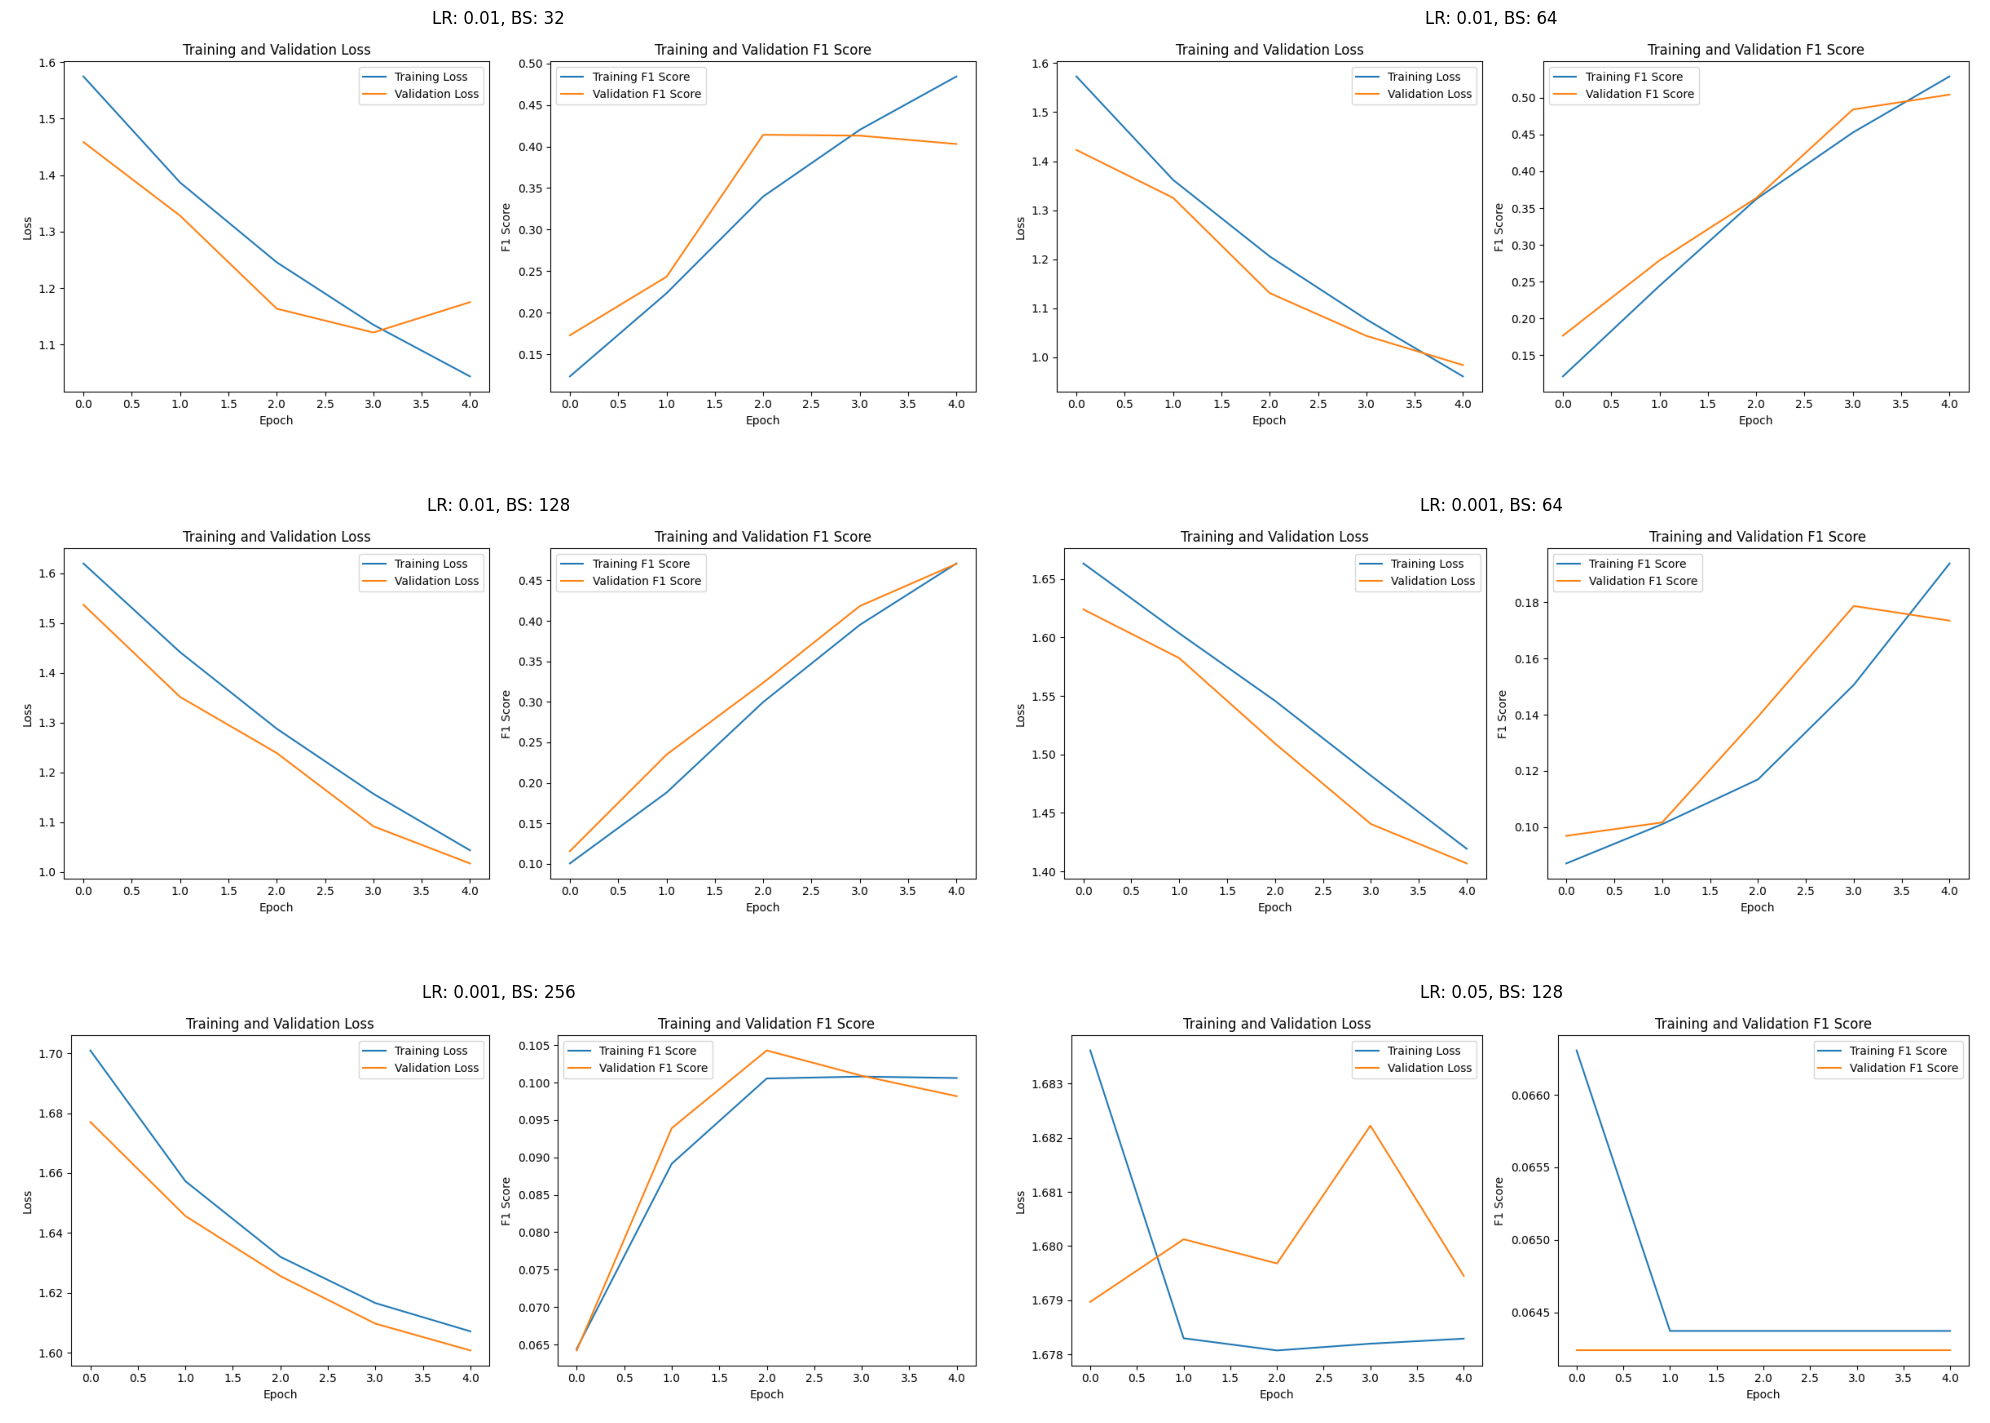

In [34]:
images = ['plots/epcs_5__lr_0.01__bs_32.png',
          'plots/epcs_5__lr_0.01__bs_64.png',
          'plots/epcs_5__lr_0.01__bs_128.png',
          'plots/epcs_5__lr_0.001__bs_64.png',
          'plots/epcs_5__lr_0.001__bs_256.png',
          'plots/epcs_5__lr_0.05__bs_128.png']

# Create a plot to display the 3x2 grid of images
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Loop through each image and plot them
for i, img_path in enumerate(images):
    # Open the image
    img = Image.open(img_path)

    # Extract the learning rate and batch size from the filename
    lr_match = re.search(r'lr_([0-9.]+)', img_path)
    bs_match = re.search(r'bs_(\d+)', img_path)

    lr = lr_match.group(1) if lr_match else 'N/A'
    bs = bs_match.group(1) if bs_match else 'N/A'

    # Set the subtitle with the batch size and learning rate
    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"LR: {lr}, BS: {bs}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

From the plots, we can certainly rule out the batch size value of 0.05 (last plot), because it leads to divergence of the loss. Furthermore, an initial learning rate of 0.01 assures faster convergence with respect to 0.001. Finally, a batch size equal to 128 seems to assure the best F1 and loss trend (the smaller batch sizes, i.e. 32 and 64, seem to be prone to overfitting). Thus, the optimal combination results to be **batch size = 128** and **learning rate = 0.01**.

## 4.3 Final training

For the final training, the network is trained for 15 epochs using a **Cosine Annealing Learning Rate Schedule**.

In [ ]:
################################ USING THE OPTIMAL HYPERPARAMETER VALUES #########################################
BATCH_SIZE, LEARNING_RATE = 128, 0.01
EPOCHS = 15

print(f'**********************************TRAINING THE MODEL FOR {EPOCHS} EPOCHS, BATCH SIZE = {BATCH_SIZE} AND INITIAL LEARNING RATE = {LEARNING_RATE}**********************************')

# Create data loaders for train, validation and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

############################### INSTANTIATING THE MODEL #################################################
net = Net(9).to(device)
print(net)

############################### DEFINING THE LOSS, THE OPTIMIZER AND THE SCHEDULER #####################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
early_stopper = EarlyStopper(patience=3, min_delta=0.03)

############################### TRAINING THE MODEL ######################################################
train(net, EPOCHS, LEARNING_RATE, BATCH_SIZE, optimizer, criterion, scheduler, early_stopper, train_loader, validation_loader)

**Results:**

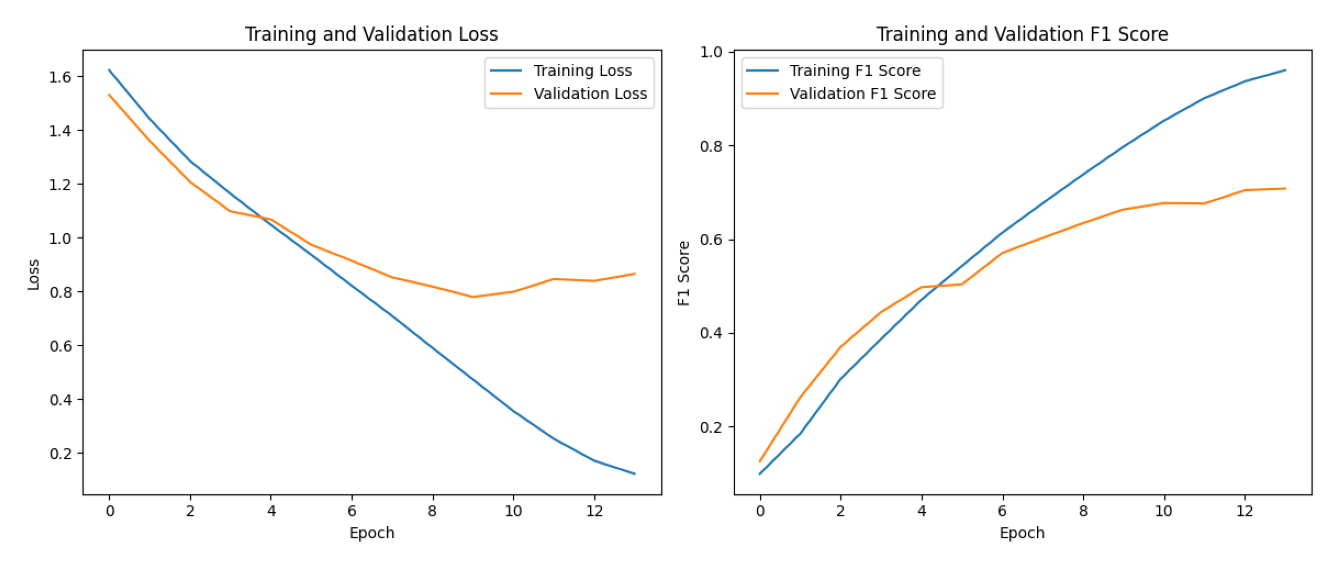

In [235]:
image_path = "epcs_15__lr_0.01__bs_128.png"

# Open and display the image
img = Image.open(image_path)

plt.figure(figsize=(17, 17))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# 5. Evaluating the network

This step involves the evaluation of the network's performance according to 'traditional' metrics (accuracy, F1 scores) and fairness metrics, which are specifically designed to assess the presence of bias.

First, we retrieve the predictions of the network on the test set:

In [ ]:
#net = Net(9)
#net.load_state_dict(torch.load('drive/MyDrive/weights/epcs_15__lr_0.01__bs_128_LASTEPOCH.pth'))
#net.to(device)

In [861]:
net.eval()

# prepare to store the predictions for the computation of the FAIRNESS METRICS
pred_fairness = []
labels_fairness = []
skin_labels_fairness = []

# again no gradients needed
with torch.no_grad():
    for data in tqdm(test_loader):
        images, skin_labels, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class and skin color for the computation of ACCURACY
        for label, prediction, skin_label in zip(labels.tolist(), predictions, skin_labels):
            pred_fairness.append(prediction)
            labels_fairness.append(label)
            skin_labels_fairness.append(skin_label)

  0%|          | 0/516 [00:00<?, ?it/s]

## 5.1 Accuracy and F1 score

We compute the overall accuracy and F1 score:

In [217]:
from sklearn.metrics import f1_score, accuracy_score

print(f"Overall accuracy: {accuracy_score(labels_fairness, pred_fairness)*100:.1f}%")
print(f"Overall F1 score: {f1_score(labels_fairness, pred_fairness, average='weighted'):.2f}")

Overall accuracy: 77.0%
Overall F1 score: 0.77


We evaluate the accuracy of the network for every skin tone.

In [200]:
from collections import defaultdict

def compute_accuracy_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness):
    """
    Compute accuracy for each unique skin label.
    
    Parameters:
    - pred_fairness: List of model predictions.
    - labels_fairness: List of true labels.
    - skin_labels_fairness: List of skin labels corresponding to each prediction/label.
    
    Returns:
    - accuracy_by_skin_label: Dictionary with skin labels as keys and accuracy as values.
    """
    
    # Dictionary to hold counts of correct predictions and total samples per skin label
    correct_predictions = defaultdict(int)
    total_samples = defaultdict(int)
    
    # Iterate through predictions, true labels, and skin labels
    for pred, true_label, skin_label in zip(pred_fairness, labels_fairness, skin_labels_fairness):
        total_samples[skin_label] += 1  # Count the sample for this skin label
        if pred == true_label:
            correct_predictions[skin_label] += 1  # Count correct prediction if it matches the true label
    
    # Calculate accuracy per skin label
    accuracy_by_skin_label = {
        skin_label: correct_predictions[skin_label] / total_samples[skin_label]
        for skin_label in total_samples
    }
    
    return accuracy_by_skin_label

accuracy_per_skin_label = compute_accuracy_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness)

for item in accuracy_per_skin_label:
    print(f'Accuracy for skin tone {item}: {accuracy_per_skin_label[item]*100:.1f}%')

Accuracy for skin tone light: 76.5%
Accuracy for skin tone very light: 82.0%
Accuracy for skin tone tan: 75.5%
Accuracy for skin tone intermediate: 75.1%
Accuracy for skin tone brown: 78.2%
Accuracy for skin tone dark: 78.4%


We also evaluate the F1 score of the network for every skin tone.

In [215]:
from sklearn.metrics import f1_score
from collections import defaultdict

def compute_f1_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness):
    """
    Compute F1 score for each unique skin label using sklearn's f1_score function.
    
    Parameters:
    - pred_fairness: List of model predictions.
    - labels_fairness: List of true labels.
    - skin_labels_fairness: List of skin labels corresponding to each prediction/label.
    
    Returns:
    - f1_by_skin_label: Dictionary with skin labels as keys and F1 scores as values.
    """
    
    # Dictionary to hold F1 scores for each skin label
    f1_by_skin_label = {}

    # Get unique skin labels
    unique_skin_labels = set(skin_labels_fairness)
    
    # Calculate F1 score for each skin label
    for skin_label in unique_skin_labels:
        # Filter predictions and true labels by current skin label
        indices = [i for i, label in enumerate(skin_labels_fairness) if label == skin_label]
        filtered_preds = [pred_fairness[i] for i in indices]
        filtered_labels = [labels_fairness[i] for i in indices]
        
        # Calculate F1 score for the current skin label
        f1 = f1_score(filtered_labels, filtered_preds, average='macro')
        f1_by_skin_label[skin_label] = f1
    
    return f1_by_skin_label

f1_per_skin_label = compute_f1_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness)

for item in f1_per_skin_label:
    print(f'F1 score for skin tone {item}: {f1_per_skin_label[item]:.2f}')

F1 score for skin tone very light: 0.75
F1 score for skin tone brown: 0.71
F1 score for skin tone light: 0.68
F1 score for skin tone intermediate: 0.68
F1 score for skin tone dark: 0.74
F1 score for skin tone tan: 0.69


Additionally, we show the overall confusion matrices for each skin tone.

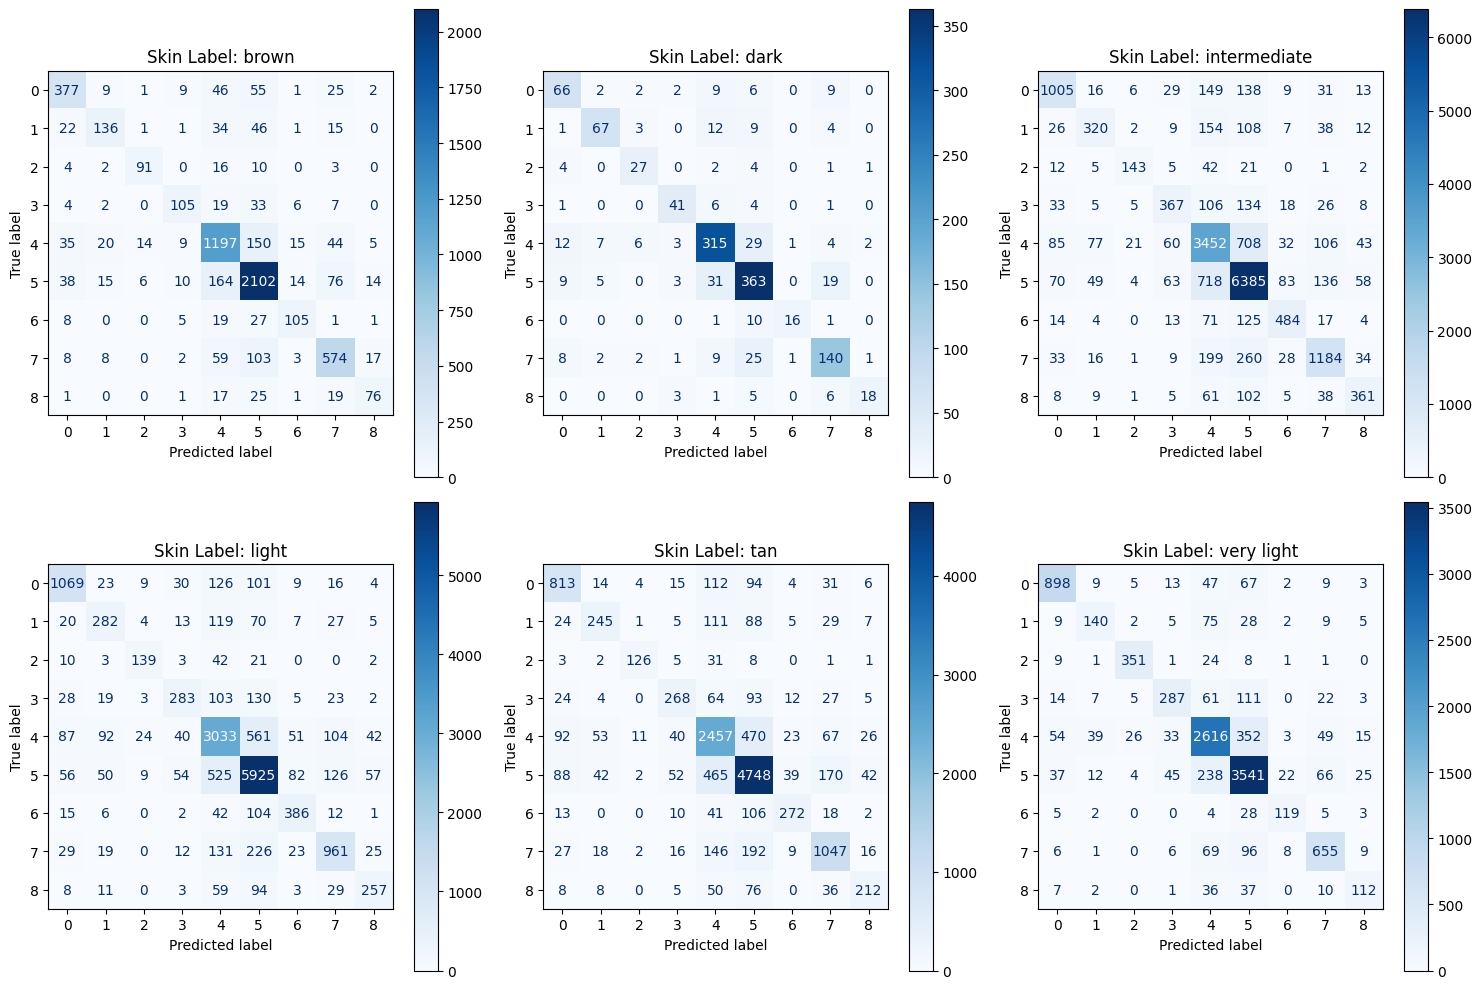

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays for easier processing
labels_fairness = np.array(labels_fairness)
pred_fairness = np.array(pred_fairness)
skin_labels_fairness = np.array(skin_labels_fairness)

# Get unique skin labels
unique_skin_labels = np.unique(skin_labels_fairness)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot confusion matrices for each skin label
for i, skin_label in enumerate(unique_skin_labels):
    # Filter labels and predictions for the current skin label
    indices = np.where(skin_labels_fairness == skin_label)
    filtered_labels = labels_fairness[indices]
    filtered_predictions = pred_fairness[indices]

    # Compute confusion matrix
    cm = confusion_matrix(filtered_labels, filtered_predictions)
    
    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot the confusion matrix on the corresponding subplot
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    axes[i].set_title(f"Skin Label: {skin_label}")

# Adjust layout
plt.tight_layout()
plt.show()

From now on, we will consider the following aggregation for the skin tones: 
- "brown", "dark" ---> Minority
- all the other skin tones ---> Majority

We compute the overall Accuracy and F1 score values for the Minority and the Majority groups:

In [239]:
pred_min = [pred_fairness[i] for i in range(len(pred_fairness)) if groups[i] == 'minority']
labels_min = [labels_fairness[i] for i in range(len(labels_fairness)) if groups[i] == 'minority']

pred_maj = [pred_fairness[i] for i in range(len(pred_fairness)) if groups[i] == 'majority']
labels_maj = [labels_fairness[i] for i in range(len(labels_fairness)) if groups[i] == 'majority']

print(f'Overall Minority F1: {f1_score(labels_min, pred_min, average='macro'):.2f},\
      Overall Majority F1: {f1_score(labels_maj, pred_maj, average='macro'):.2f}')
print(f'Overall Minority Accuracy: {accuracy_score(labels_min, pred_min)*100:.1f}%,\
      Overall Majority Accuracy: {accuracy_score(labels_maj, pred_maj)*100:.1f}%')

Overall Minority F1: 0.72,      Overall Majority F1: 0.70
Overall Minority Accuracy: 78.2%,      Overall Majority Accuracy: 76.8%


Second, we compute the Accuracy and the F1 score values for each skin disease, both for the Majority and Minority group.

In [240]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(len(diseases)):
    correct_pred_min = 0
    correct_pred_maj = 0
    pred_min = 0
    pred_maj = 0

    for i in range(len(groups)):
        if labels_fairness[i] == disease_id:
            if groups[i] == 'majority':
                pred_maj += 1
                if labels_fairness[i] == pred_fairness[i]:
                    correct_pred_maj += 1
            elif groups[i] == 'minority':
                pred_min += 1
                if labels_fairness[i] == pred_fairness[i]:
                    correct_pred_min += 1
    
    print(f'Disease {disease_id}: Minority Accuracy: {correct_pred_min/pred_min*100:.1f}%, Majority Accuracy: {correct_pred_maj/pred_maj*100:.1f}%')

Disease 0: Minority Accuracy: 71.3%, Majority Accuracy: 76.8%
Disease 1: Minority Accuracy: 57.7%, Majority Accuracy: 49.0%
Disease 2: Minority Accuracy: 71.5%, Majority Accuracy: 74.1%
Disease 3: Minority Accuracy: 63.8%, Majority Accuracy: 52.3%
Disease 4: Minority Accuracy: 80.9%, Majority Accuracy: 76.8%
Disease 5: Minority Accuracy: 85.9%, Majority Accuracy: 85.5%
Disease 6: Minority Accuracy: 62.4%, Majority Accuracy: 65.4%
Disease 7: Minority Accuracy: 74.1%, Majority Accuracy: 69.8%
Disease 8: Minority Accuracy: 54.3%, Majority Accuracy: 57.0%


In [220]:
for disease_id in range(len(diseases)):
    pred_min = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness)) if groups[i] == 'minority']
    labels_min = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness)) if groups[i] == 'minority']

    pred_maj = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness)) if groups[i] == 'majority']
    labels_maj = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness)) if groups[i] == 'majority']

    print(f'Disease {disease_id}: Minority F1: {f1_score(labels_min, pred_min):.2f}, Majority F1: {f1_score(labels_maj, pred_maj):.2f}')

Disease 0: Minority F1: 0.73, Majority F1: 0.78
Disease 1: Minority F1: 0.65, Majority F1: 0.55
Disease 2: Minority F1: 0.74, Majority F1: 0.78
Disease 3: Minority F1: 0.69, Majority F1: 0.59
Disease 4: Minority F1: 0.79, Majority F1: 0.75
Disease 5: Minority F1: 0.84, Majority F1: 0.83
Disease 6: Minority F1: 0.68, Majority F1: 0.69
Disease 7: Minority F1: 0.75, Majority F1: 0.72
Disease 8: Minority F1: 0.61, Majority F1: 0.61


We also provide the confusion matrices for the Majority and Minority group.

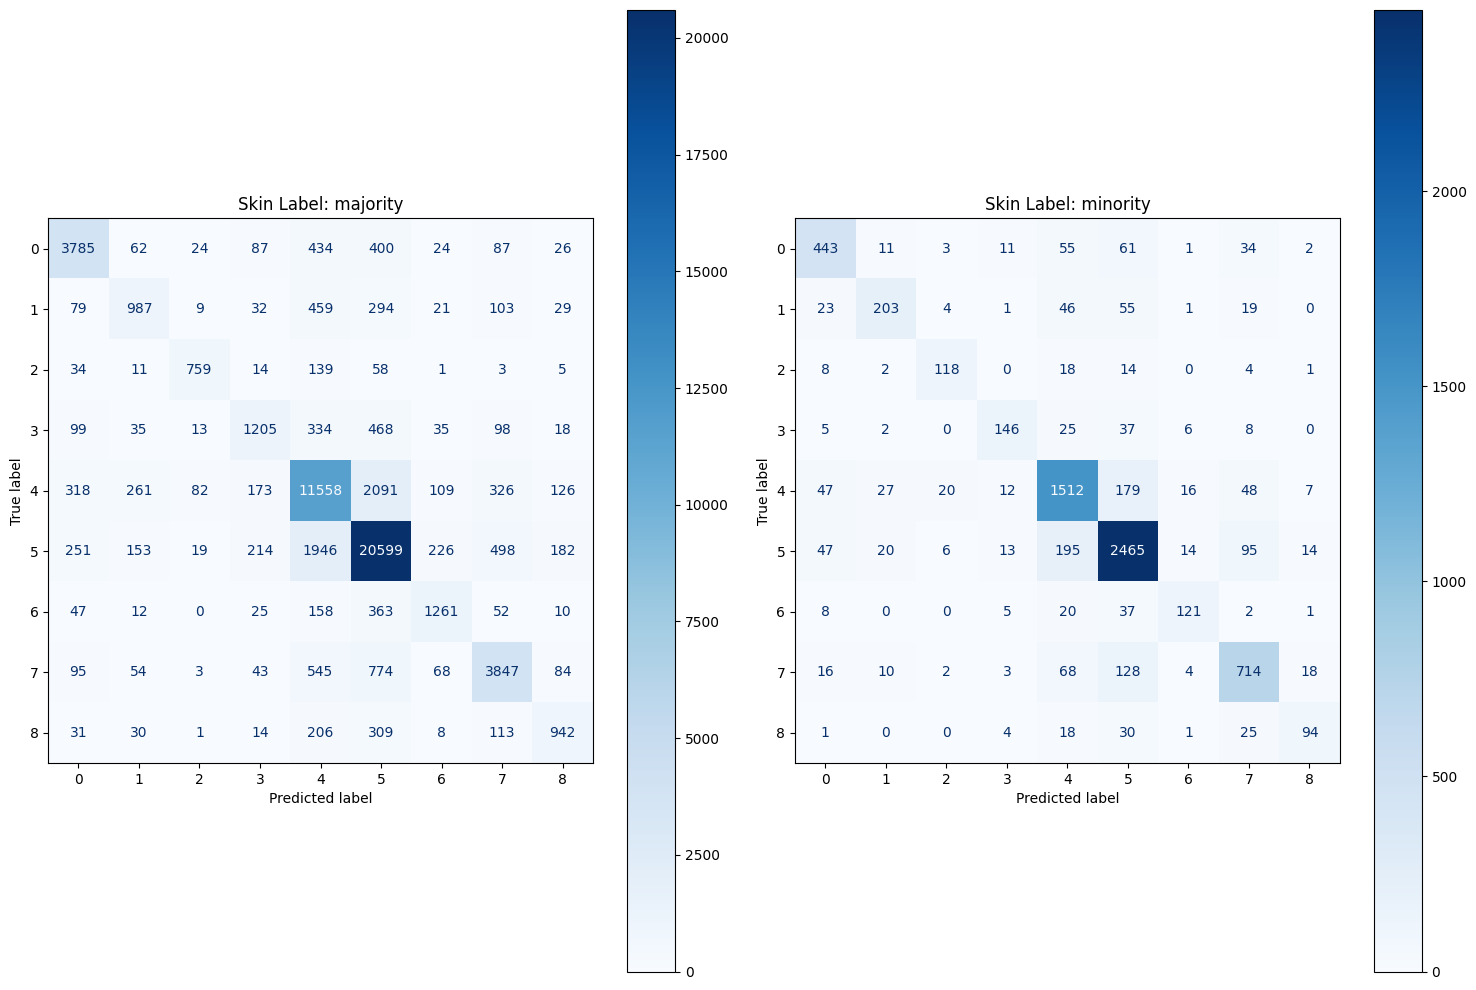

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays for easier processing
labels_fairness = np.array(labels_fairness)
pred_fairness = np.array(pred_fairness)
groups = np.array(['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))])

# Get unique skin labels
unique_skin_labels = np.unique(groups)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot confusion matrices for each skin label
for i, skin_label in enumerate(unique_skin_labels):
    # Filter labels and predictions for the current skin label
    indices = np.where(groups == skin_label)
    filtered_labels = labels_fairness[indices]
    filtered_predictions = pred_fairness[indices]

    # Compute confusion matrix
    cm = confusion_matrix(filtered_labels, filtered_predictions)
    
    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot the confusion matrix on the corresponding subplot
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    axes[i].set_title(f"Skin Label: {skin_label}")

# Adjust layout
plt.tight_layout()
plt.show()

## 5.2 Fairness metrics

### 5.2.1 Disparate Impact

In the binary case, **disparate impact** is defined as
$$\frac{Pr(\hat{Y} = 1 | X \in minority\_group)}{Pr(\hat{Y} = 1 | X \in majority\_group)}$$
i.e. the ratio between the selection rate for the minority and majority group. In our case, we have a multiclass task at hand. We handle it by computing the Disparate Impact for each disease, considering $\hat{Y} = 1$ if the single disease is detected, $\hat{Y} = 0$ otherwise. Plus, we aggregate the skin tones considering the *brown* and *dark* skin tones as the **minority group** and the remaining four skin tones as the **majority group**.
The disparate impact is computed using the implementation provided by the library *holisticai*.

In [222]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(9):
  # Initialize empty lists for minority and majority groups
  pred_list = []
  labels_list = []
  minority_list = []
  majority_list = []

  # Loop through skin_labels_fairness and check the group
  for i in range(len(pred_fairness)):
      pred_list.append(1 if pred_fairness[i] == disease_id else 0)
      labels_list.append(1 if labels_fairness[i] == disease_id else 0)

      if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown':
          minority_list.append(1)
          majority_list.append(0)
      else:
          minority_list.append(0)
          majority_list.append(1)

  print(f'Disparate impact for disease {diseases[disease_id]}: {disparate_impact(minority_list, majority_list, pred_list):.2f}', '\n')

Disparate impact for disease esantema-iatrogeno-farmaco-indotta: 0.99 

Disparate impact for disease esantema-maculo-papuloso: 1.35 

Disparate impact for disease esantema-morbilliforme: 1.32 

Disparate impact for disease esantema-polimorfo-like: 0.85 

Disparate impact for disease esantema-virale: 0.98 

Disparate impact for disease orticaria: 0.93 

Disparate impact for disease pediculosi: 0.74 

Disparate impact for disease scabbia: 1.46 

Disparate impact for disease varicella: 0.76 



### 5.2.2 Equalized Odds Ratio


A classifier satisfies Equalized Odds under a distribution over (X, A, Y ) (where A indicates the sensitive feature) if its prediction $\hat{Y}$ is conditionally independent of the sensitive feature A given the label Y . This is equivalent to $E(\hat{Y} |A = a, Y = y) = E(\hat{Y} |Y = y) \; ∀ \; a, y.$ Equalized odds requires that the true positive rate, $Pr(\hat{Y} = 1|Y = 1)$, and the false positive rate, $Pr(\hat{Y} = 1|Y = 0)$, are equal across groups. In our case, Equalized Odds Ratio (EOR) was computed for every disease using the implementation of the library **fairlearn**, in which EOR is defined as 'the smaller of two metrics: *true positive rate ratio* and *false positive rate ratio*. The former is the ratio between the smallest and largest of $Pr(\hat{Y} = 1|A = a, Y = 1)$, across all values of the sensitive feature(s). The latter is defined similarly, but for $Pr(\hat{Y} = 1|A = a, Y = 0)$. The equalized odds ratio of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates’ [https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.equalized_odds_ratio.html#fairlearn.metrics.equalized_odds_ratio]. Even in this case, the skin tones were aggregated into the same two groups used to compute the Disparate Impact Ratio.

In [181]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(len(diseases)):
  preds = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness))]
  labels = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness))]

  print(f'Equalized Odds Ratio for {diseases[disease_id]}: {equalized_odds_ratio(labels, preds, sensitive_features=groups):.2f}', '\n')

Equalized Odds Ratio for esantema-iatrogeno-farmaco-indotta: 0.78 

Equalized Odds Ratio for esantema-maculo-papuloso: 0.85 

Equalized Odds Ratio for esantema-morbilliforme: 0.55 

Equalized Odds Ratio for esantema-polimorfo-like: 0.63 

Equalized Odds Ratio for esantema-virale: 0.82 

Equalized Odds Ratio for orticaria: 0.86 

Equalized Odds Ratio for pediculosi: 0.68 

Equalized Odds Ratio for scabbia: 0.67 

Equalized Odds Ratio for varicella: 0.70 



### 5.2.3 Predictive Rate Ratio

The **Predictive Rate Parity** is achieved if the **Positive Predictive Value (PPV)**, also named as **precision**, is the same across all groups. The formula for the precision is
$$
PPV = \frac{True \; Positives \; (TP)}{True \; Positives \; (TP) + False \; Positives \; (FP)}
$$
The **Predictive Rate Ratio** compares the precision between the two groups. It is calculated by taking the ratio of the PPV of one group to the PPV of another group:
$$
Predictive \; Rate \; Ratio = \frac{PPV_{minority\_group}}{PPV_{majority\_group}}
$$
In our implementation, we compute this value for each disease, with the usual division of the skin tones into the minority group and majority group. <br> <br>
We can retrieve the Predictive Rate Ratio value by considering the precision matrix relative to each disease for the minority and majority group. The function for the precision matrix is taken from the library **holisticai**. Observing the matrix, we simply compute the ratio between the precision of the minority group and of the majority group.

In [223]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]
prec_matrix = precision_matrix(groups, pred_fairness, labels_fairness)
prec_matrix.head()

,0,1,2,3,4,5,6,7,8
majority,0.767904,0.490313,0.741211,0.522777,0.768280,0.855156,0.654046,0.697805,0.569528
minority,0.713366,0.576705,0.715152,0.637555,0.809422,0.859184,0.623711,0.741433,0.543353


In [224]:
for disease_id in range(len(diseases)):
  prr = prec_matrix.iloc[1,disease_id] / prec_matrix.iloc[0,disease_id]
  print(f'Predictive Rate Ratio for disease {diseases[disease_id]}: {prr:.2f}', '\n')

Predictive Rate Ratio for disease esantema-iatrogeno-farmaco-indotta: 0.93 

Predictive Rate Ratio for disease esantema-maculo-papuloso: 1.18 

Predictive Rate Ratio for disease esantema-morbilliforme: 0.96 

Predictive Rate Ratio for disease esantema-polimorfo-like: 1.22 

Predictive Rate Ratio for disease esantema-virale: 1.05 

Predictive Rate Ratio for disease orticaria: 1.00 

Predictive Rate Ratio for disease pediculosi: 0.95 

Predictive Rate Ratio for disease scabbia: 1.06 

Predictive Rate Ratio for disease varicella: 0.95 

